In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
from typing import List
import time
from scipy import stats
from scipy.stats import zscore
import random
import sys

%matplotlib inline
start_time = pd.datetime.now()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [2]:
from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

%matplotlib inline

In [3]:
data = pd.read_csv('applications data.csv',parse_dates = ['date'])
data.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,2016-01-01,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0


## Data Cleaning
According to the data quality report, there are many frivolous values( 999999999, 9999999999, 19070626, 123 MAIN ST) in some fields(ssn, homephone, dob, adress). Frivolous values are very common in application dataset due to resons such as privacy issues. These kind of values need to be cleand to avoid essential errors in final results. So I decides to replace those values with some unique neutral values

In [4]:
data['ssn'] = np.where(data['ssn'] == 999999999, data['record'], data['ssn'])
data['homephone'] = np.where(data['homephone'] == 9999999999,data['record'], data['homephone'])
data['address']= np.where(data['address'] == '123 MAIN ST',data['record'],data['address'])
data['dob'] = np.where(data['dob'] == 19070626, data['record'],data['dob'])

In [5]:
df1 = deepcopy(data)

## Feature Engineering

In [6]:
# Convert numeric fields to 'object' data type so I can combine variables as strings
cols_to_obj = ['record', 'ssn', 'firstname', 'lastname', 'address',
       'zip5', 'dob', 'homephone']
for col in cols_to_obj:
    df1[col] = df1[col].astype(str)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   record       1000000 non-null  object        
 1   date         1000000 non-null  datetime64[ns]
 2   ssn          1000000 non-null  object        
 3   firstname    1000000 non-null  object        
 4   lastname     1000000 non-null  object        
 5   address      1000000 non-null  object        
 6   zip5         1000000 non-null  object        
 7   dob          1000000 non-null  object        
 8   homephone    1000000 non-null  object        
 9   fraud_label  1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 76.3+ MB


In [7]:
# Combine variables to create new variables
df1['name'] = df1['firstname'] + df1['lastname']
df1['fullAddress'] = df1['address'] + df1['zip5']

df1['name_ssn'] = df1['name'] + df1['ssn']
df1['name_homephone'] = df1['name'] + df1['homephone'] 
df1['name_address'] = df1['name'] + df1['address']
df1['name_zip'] = df1['name'] + df1['zip5'] 
df1['name_fullAddress'] = df1['name'] + df1['fullAddress']
df1['name_dob'] = df1['name'] + df1['dob']
df1['name_dob_ssn'] = df1['ssn'] + df1['name_dob']
df1['name_dob_homephone'] = df1['name_dob'] + df1['homephone'] 
df1['name_dob_zip'] = df1['name_dob'] + df1['zip5']
df1['name_dob_address'] = df1['name_dob'] + df1['address']
df1['name_dob_fullAddress'] = df1['name_dob'] + df1['fullAddress']

df1['ssn_firstname'] = df1['ssn'] + df1['firstname'] 
df1['ssn_lastname'] = df1['ssn'] + df1['lastname'] 
df1['ssn_dob'] = df1['ssn'] + df1['dob'] 
df1['ssn_homephone'] = df1['ssn'] + df1['homephone']
df1['ssn_zip'] = df1['ssn'] + df1['zip5'] 
df1['ssn_address'] = df1['ssn'] + df1['address'] 
df1['ssn_fullAddress'] = df1['ssn'] + df1['fullAddress']

df1['dob_firstname'] = df1['dob'] + df1['firstname']
df1['dob_lastname'] = df1['dob'] + df1['lastname']
df1['dob_zip'] = df1['dob'] + df1['zip5']
df1['dob_address'] = df1['dob'] + df1['address']
df1['dob_homephone'] = df1['dob'] + df1['homephone']
df1['dob_fullAddress'] = df1['dob'] + df1['fullAddress']

df1['homephone_address'] = df1['homephone'] + df1['address'] 
df1['homephone_zip'] = df1['homephone'] + df1['zip5']
df1['homephone_fullAddress']= df1['homephone'] + df1['fullAddress']

In [8]:
df1.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,name,fullAddress,name_ssn,name_homephone,name_address,name_zip,name_fullAddress,name_dob,name_dob_ssn,name_dob_homephone,name_dob_zip,name_dob_address,name_dob_fullAddress,ssn_firstname,ssn_lastname,ssn_dob,ssn_homephone,ssn_zip,ssn_address,ssn_fullAddress,dob_firstname,dob_lastname,dob_zip,dob_address,dob_homephone,dob_fullAddress,homephone_address,homephone_zip,homephone_fullAddress
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,1,1797504115,0,XRRAMMTRSMJETJMJ,6861 EUTST PL2765,XRRAMMTRSMJETJMJ379070012,XRRAMMTRSMJETJMJ1797504115,XRRAMMTRSMJETJMJ6861 EUTST PL,XRRAMMTRSMJETJMJ2765,XRRAMMTRSMJETJMJ6861 EUTST PL2765,XRRAMMTRSMJETJMJ1,379070012XRRAMMTRSMJETJMJ1,XRRAMMTRSMJETJMJ11797504115,XRRAMMTRSMJETJMJ12765,XRRAMMTRSMJETJMJ16861 EUTST PL,XRRAMMTRSMJETJMJ16861 EUTST PL2765,379070012XRRAMMTR,379070012SMJETJMJ,3790700121,3790700121797504115,3790700122765,3790700126861 EUTST PL,3790700126861 EUTST PL2765,1XRRAMMTR,1SMJETJMJ,12765,16861 EUTST PL,11797504115,16861 EUTST PL2765,17975041156861 EUTST PL,17975041152765,17975041156861 EUTST PL2765
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1,MAMSTUJRRTTEMRRR,7280 URASA PL57169,MAMSTUJRRTTEMRRR387482503,MAMSTUJRRTTEMRRR4164239415,MAMSTUJRRTTEMRRR7280 URASA PL,MAMSTUJRRTTEMRRR57169,MAMSTUJRRTTEMRRR7280 URASA PL57169,MAMSTUJRRTTEMRRR19340615,387482503MAMSTUJRRTTEMRRR19340615,MAMSTUJRRTTEMRRR193406154164239415,MAMSTUJRRTTEMRRR1934061557169,MAMSTUJRRTTEMRRR193406157280 URASA PL,MAMSTUJRRTTEMRRR193406157280 URASA PL57169,387482503MAMSTUJR,387482503RTTEMRRR,38748250319340615,3874825034164239415,38748250357169,3874825037280 URASA PL,3874825037280 URASA PL57169,19340615MAMSTUJR,19340615RTTEMRRR,1934061557169,193406157280 URASA PL,193406154164239415,193406157280 URASA PL57169,41642394157280 URASA PL,416423941557169,41642394157280 URASA PL57169
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,3,216537580,0,SZMMUJEZSEUSEZRAE,5581 RSREX LN56721,SZMMUJEZSEUSEZRAE200332444,SZMMUJEZSEUSEZRAE216537580,SZMMUJEZSEUSEZRAE5581 RSREX LN,SZMMUJEZSEUSEZRAE56721,SZMMUJEZSEUSEZRAE5581 RSREX LN56721,SZMMUJEZSEUSEZRAE3,200332444SZMMUJEZSEUSEZRAE3,SZMMUJEZSEUSEZRAE3216537580,SZMMUJEZSEUSEZRAE356721,SZMMUJEZSEUSEZRAE35581 RSREX LN,SZMMUJEZSEUSEZRAE35581 RSREX LN56721,200332444SZMMUJEZS,200332444EUSEZRAE,2003324443,200332444216537580,20033244456721,2003324445581 RSREX LN,2003324445581 RSREX LN56721,3SZMMUJEZS,3EUSEZRAE,356721,35581 RSREX LN,3216537580,35581 RSREX LN56721,2165375805581 RSREX LN,21653758056721,2165375805581 RSREX LN56721
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0,SJJZSXRSZETJXTXXS,1387 UJZXJ RD35286,SJJZSXRSZETJXTXXS747451317,SJJZSXRSZETJXTXXS132144161,SJJZSXRSZETJXTXXS1387 UJZXJ RD,SJJZSXRSZETJXTXXS35286,SJJZSXRSZETJXTXXS1387 UJZXJ RD35286,SJJZSXRSZETJXTXXS19440430,747451317SJJZSXRSZETJXTXXS19440430,SJJZSXRSZETJXTXXS19440430132144161,SJJZSXRSZETJXTXXS1944043035286,SJJZSXRSZETJXTXXS194404301387 UJZXJ RD,SJJZSXRSZETJXTXXS194404301387 UJZXJ RD35286,747451317SJJZSXRSZ,747451317ETJXTXXS,74745131719440430,747451317132144161,74745131735286,7474513171387 UJZXJ RD,7474513171387 UJZXJ RD35286,19440430SJJZSXRSZ,19440430ETJXTXXS,1944043035286,194404301387 UJZXJ RD,19440430132144161,194404301387 UJZXJ RD35286,1321441611387 UJZXJ RD,13214416135286,1321441611387 UJZXJ RD35286
4,5,2016-01-01,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0,SSSXUEJMSSSUUJXUZ,279 EAASA WY3173,SSSXUEJMSSSUUJXUZ24065868,SSSXUEJMSSSUUJXUZ6101082272,SSSXUEJMSSSUUJXUZ279 EAASA WY,SSSXUEJMSSSUUJXUZ3173,SSSXUEJMSSSUUJXUZ279 EAASA WY3173,SSSXUEJMSSSUUJXUZ19980315,24065868SSSXUEJMSSSUUJXUZ19980315,SSSXUEJMSSSUUJXUZ199803156101082272,SSSXUEJMSSSUUJXUZ199803153173,SSSXUEJMSSSUUJXUZ19980315279 EAASA WY,SSSXUEJMSSSUUJXUZ19980315279 EAASA WY3173,24065868SSSXUEJMS,24065868SSUUJXUZ,2406586819980315,240658686101082272,240658683173,24065868279 EAASA W

In [9]:
# convert variabls back to int type for calculation 
cols_num = ['record','ssn','zip5','dob','homephone','ssn_dob','ssn_zip', 'dob_zip','dob_homephone','homephone_zip']
for col in cols_num:
    df1[col] = df1[col].astype('int64')
df1.dtypes

record                            int64
date                     datetime64[ns]
ssn                               int64
firstname                        object
lastname                         object
address                          object
zip5                              int64
dob                               int64
homephone                         int64
fraud_label                       int64
name                             object
fullAddress                      object
name_ssn                         object
name_homephone                   object
name_address                     object
name_zip                         object
name_fullAddress                 object
name_dob                         object
name_dob_ssn                     object
name_dob_homephone               object
name_dob_zip                     object
name_dob_address                 object
name_dob_fullAddress             object
ssn_firstname                    object
ssn_lastname                     object


In [10]:
cols_comb = list(df1.columns.drop(['record','date','firstname','lastname','zip5','fraud_label']))

# Time-period-based columns
time_period = [0,1,3,7,14,30,90,180]
time_joined =['join_ts1']
for num in time_period:
    time_joined.append('join_ts2_'+str(num))
    
df2 = deepcopy(df1)
df2['join_ts1'] = df2['date']
for time in time_period:
    temp_endTime = 'join_ts2_' + str(time)
    df2[temp_endTime] = df2['date'] + dt.timedelta(time)


### Create Expert Variables

In [11]:
# velocity variables
df_final = deepcopy(df1.set_index('record'))

for col in cols_comb:
    df3 = df1[['record','date',col]]
    temp = time_joined + [col]
    df4 = df2[temp]
    
    df_temp = pd.merge(df3,df4,left_on = [col], right_on = [col])
    
    for time in time_period:
        temp_endTime = 'join_ts2_' + str(time)
        df_temp2 = df_temp[(df_temp['date'] >= df_temp['join_ts1']) & (df_temp['date'] <= df_temp[temp_endTime])]
        df_groupby = df_temp2[['record','date']].groupby('record')
        
        temp_name = col + '_' + 'velocity' + str(time) + '_'
        
        df_final= pd.merge(df_final, getattr(df_groupby,'count')().add_prefix(temp_name),\
                            left_index=True, right_index=True, how='left')
df_final.head()        
        

,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,name,fullAddress,name_ssn,name_homephone,name_address,name_zip,name_fullAddress,name_dob,name_dob_ssn,name_dob_homephone,name_dob_zip,name_dob_address,name_dob_fullAddress,ssn_firstname,ssn_lastname,ssn_dob,ssn_homephone,ssn_zip,ssn_address,ssn_fullAddress,dob_firstname,dob_lastname,dob_zip,dob_address,dob_homephone,dob_fullAddress,homephone_address,homephone_zip,homephone_fullAddress,ssn_velocity0_date,ssn_velocity1_date,ssn_velocity3_date,ssn_velocity7_date,ssn_velocity14_date,ssn_velocity30_date,ssn_velocity90_date,ssn_velocity180_date,address_velocity0_date,address_velocity1_date,address_velocity3_date,address_velocity7_date,address_velocity14_date,address_velocity30_date,address_velocity90_date,address_velocity180_date,dob_velocity0_date,dob_velocity1_date,dob_velocity3_date,dob_velocity7_date,dob_velocity14_date,dob_velocity30_date,dob_velocity90_date,dob_velocity180_date,homephone_velocity0_date,homephone_velocity1_date,homephone_velocity3_date,homephone_velocity7_date,homephone_velocity14_date,homephone_velocity30_date,homephone_velocity90_date,homephone_velocity180_date,name_velocity0_date,name_velocity1_date,name_velocity3_date,name_velocity7_date,name_velocity14_date,name_velocity30_date,name_velocity90_date,name_velocity180_date,fullAddress_velocity0_date,fullAddress_velocity1_date,fullAddress_velocity3_date,fullAddress_velocity7_date,fullAddress_velocity14_date,fullAddress_velocity30_date,fullAddress_velocity90_date,fullAddress_velocity180_date,name_ssn_velocity0_date,name_ssn_velocity1_date,name_ssn_velocity3_date,name_ssn_velocity7_date,name_ssn_velocity14_date,name_ssn_velocity30_date,name_ssn_velocity90_date,name_ssn_velocity180_date,name_homephone_velocity0_date,name_homephone_velocity1_date,name_homephone_velocity3_date,name_homephone_velocity7_date,name_homephone_velocity14_date,name_homephone_velocity30_date,name_homephone_velocity90_date,name_homephone_velocity180_date,name_address_velocity0_date,name_address_velocity1_date,name_address_velocity3_date,name_address_velocity7_date,name_address_velocity14_date,name_address_velocity30_date,name_address_velocity90_date,name_address_velocity180_date,name_zip_velocity0_date,name_zip_velocity1_date,name_zip_velocity3_date,name_zip_velocity7_date,name_zip_velocity14_date,name_zip_velocity30_date,name_zip_velocity90_date,name_zip_velocity180_date,name_fullAddress_velocity0_date,name_fullAddress_velocity1_date,name_fullAddress_velocity3_date,name_fullAddress_velocity7_date,name_fullAddress_velocity14_date,name_fullAddress_velocity30_date,name_fullAddress_velocity90_date,name_fullAddress_velocity180_date,name_dob_velocity0_date,name_dob_velocity1_date,name_dob_velocity3_date,name_dob_velocity7_date,name_dob_velocity14_date,name_dob_velocity30_date,name_dob_velocity90_date,name_dob_velocity180_date,name_dob_ssn_velocity0_date,name_dob_ssn_velocity1_date,name_dob_ssn_velocity3_date,name_dob_ssn_velocity7_date,name_dob_ssn_velocity14_date,name_dob_ssn_velocity30_date,name_dob_ssn_velocity90_date,name_dob_ssn_velocity180_date,name_dob_homephone_velocity0_date,name_dob_homephone_velocity1_date,name_dob_homephone_velocity3_date,name_dob_homephone_velocity7_date,name_dob_homephone_velocity14_date,name_dob_homephone_velocity30_date,name_dob_homephone_velocity90_date,name_dob_homephone_velocity180_date,name_dob_zip_velocity0_date,name_dob_zip_velocity1_date,name_dob_zip_velocity3_date,name_dob_zip_velocity7_date,name_dob_zip_velocity14_date,name_dob_zip_velocity30_date,name_dob_zip_velocity90_date,name_dob_zip_velocity180_date,name_dob_address_velocity0_date,name_dob_address_velocity1_date,name_dob_address_velocity3_date,name_dob_address_velocity7_date,name_dob_address_velocity14_date,name_dob_address_velocity30_date,name_dob_address_velocity90_date,name_dob_address_velocity180_date,name_dob_fullAddress_velocity0_date,name_dob_fullAddress_velocity1_date,name_dob_fullAddress_velocity3_date,name_dob_fullAddress

In [12]:
# relative velocity variables
df_veloc = deepcopy(df_final)

time_numer = ['0','1']
time_denom = ['3','7','14','30','90','180']

for col in cols_comb :
    for c in time_numer:
        for d in time_denom:
            temp = d
            df_final[col + '_' + c + '_dayvel' + '_div_' + d + '_dayvel' + '_relvelocity'] = \
                df_final[col + '_velocity' + c + '_date'] / \
                (df_final[col + '_velocity' + d + '_date'] / float(temp))
df_final.head()

,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,name,fullAddress,name_ssn,name_homephone,name_address,name_zip,name_fullAddress,name_dob,name_dob_ssn,name_dob_homephone,name_dob_zip,name_dob_address,name_dob_fullAddress,ssn_firstname,ssn_lastname,ssn_dob,ssn_homephone,ssn_zip,ssn_address,ssn_fullAddress,dob_firstname,dob_lastname,dob_zip,dob_address,dob_homephone,dob_fullAddress,homephone_address,homephone_zip,homephone_fullAddress,ssn_velocity0_date,ssn_velocity1_date,ssn_velocity3_date,ssn_velocity7_date,ssn_velocity14_date,ssn_velocity30_date,ssn_velocity90_date,ssn_velocity180_date,address_velocity0_date,address_velocity1_date,address_velocity3_date,address_velocity7_date,address_velocity14_date,address_velocity30_date,address_velocity90_date,address_velocity180_date,dob_velocity0_date,dob_velocity1_date,dob_velocity3_date,dob_velocity7_date,dob_velocity14_date,dob_velocity30_date,dob_velocity90_date,dob_velocity180_date,homephone_velocity0_date,homephone_velocity1_date,homephone_velocity3_date,homephone_velocity7_date,homephone_velocity14_date,homephone_velocity30_date,homephone_velocity90_date,homephone_velocity180_date,name_velocity0_date,name_velocity1_date,name_velocity3_date,name_velocity7_date,name_velocity14_date,name_velocity30_date,name_velocity90_date,name_velocity180_date,fullAddress_velocity0_date,fullAddress_velocity1_date,fullAddress_velocity3_date,fullAddress_velocity7_date,fullAddress_velocity14_date,fullAddress_velocity30_date,fullAddress_velocity90_date,fullAddress_velocity180_date,name_ssn_velocity0_date,name_ssn_velocity1_date,name_ssn_velocity3_date,name_ssn_velocity7_date,name_ssn_velocity14_date,name_ssn_velocity30_date,name_ssn_velocity90_date,name_ssn_velocity180_date,name_homephone_velocity0_date,name_homephone_velocity1_date,name_homephone_velocity3_date,name_homephone_velocity7_date,name_homephone_velocity14_date,name_homephone_velocity30_date,name_homephone_velocity90_date,name_homephone_velocity180_date,name_address_velocity0_date,name_address_velocity1_date,name_address_velocity3_date,name_address_velocity7_date,name_address_velocity14_date,name_address_velocity30_date,name_address_velocity90_date,name_address_velocity180_date,name_zip_velocity0_date,name_zip_velocity1_date,name_zip_velocity3_date,name_zip_velocity7_date,name_zip_velocity14_date,name_zip_velocity30_date,name_zip_velocity90_date,name_zip_velocity180_date,name_fullAddress_velocity0_date,name_fullAddress_velocity1_date,name_fullAddress_velocity3_date,name_fullAddress_velocity7_date,name_fullAddress_velocity14_date,name_fullAddress_velocity30_date,name_fullAddress_velocity90_date,name_fullAddress_velocity180_date,name_dob_velocity0_date,name_dob_velocity1_date,name_dob_velocity3_date,name_dob_velocity7_date,name_dob_velocity14_date,name_dob_velocity30_date,name_dob_velocity90_date,name_dob_velocity180_date,name_dob_ssn_velocity0_date,name_dob_ssn_velocity1_date,name_dob_ssn_velocity3_date,name_dob_ssn_velocity7_date,name_dob_ssn_velocity14_date,name_dob_ssn_velocity30_date,name_dob_ssn_velocity90_date,name_dob_ssn_velocity180_date,name_dob_homephone_velocity0_date,name_dob_homephone_velocity1_date,name_dob_homephone_velocity3_date,name_dob_homephone_velocity7_date,name_dob_homephone_velocity14_date,name_dob_homephone_velocity30_date,name_dob_homephone_velocity90_date,name_dob_homephone_velocity180_date,name_dob_zip_velocity0_date,name_dob_zip_velocity1_date,name_dob_zip_velocity3_date,name_dob_zip_velocity7_date,name_dob_zip_velocity14_date,name_dob_zip_velocity30_date,name_dob_zip_velocity90_date,name_dob_zip_velocity180_date,name_dob_address_velocity0_date,name_dob_address_velocity1_date,name_dob_address_velocity3_date,name_dob_address_velocity7_date,name_dob_address_velocity14_date,name_dob_address_velocity30_date,name_dob_address_velocity90_date,name_dob_address_velocity180_date,name_dob_fullAddress_velocity0_date,name_dob_fullAddress_velocity1_date,name_dob_fullAddress_velocity3_date,name_dob_fullAddress

In [13]:
df_final['record'] = df_final.index.to_numpy()
day_since = df_final[['record']].set_index('record').copy()

In [14]:
# day since variables
for col in cols_comb:
    temp_1 = df_final[['record','date',col]]
    temp_2 = deepcopy(temp_1)
    inner_join = pd.merge(temp_1,temp_2, left_on = col, right_on = col)
    inner_join_distinct = inner_join[inner_join['record_x'] > inner_join['record_y']]
    col_name = col + '_'+ 'pastDays'
    inner_join_distinct[col_name] = (inner_join_distinct['date_x'] - inner_join_distinct['date_y']).astype('timedelta64[D]')
    temp_recent = inner_join_distinct.groupby('record_x').agg({col_name:'min'})
    day_since = pd.merge(day_since,temp_recent, left_index = True, right_index = True, how = 'left')


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [15]:
day_since.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 1 to 1000000
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ssn_pastDays                    147255 non-null  float64
 1   address_pastDays                170148 non-null  float64
 2   dob_pastDays                    830760 non-null  float64
 3   homephone_pastDays              893245 non-null  float64
 4   name_pastDays                   282874 non-null  float64
 5   fullAddress_pastDays            154198 non-null  float64
 6   name_ssn_pastDays               145283 non-null  float64
 7   name_homephone_pastDays         134536 non-null  float64
 8   name_address_pastDays           141813 non-null  float64
 9   name_zip_pastDays               142718 non-null  float64
 10  name_fullAddress_pastDays       141804 non-null  float64
 11  name_dob_pastDays               131570 non-null  float64
 12  name_dob_ssn_p

In [16]:
day_since = day_since.fillna(365)

In [17]:
day_since.head()

,ssn_pastDays,address_pastDays,dob_pastDays,homephone_pastDays,name_pastDays,fullAddress_pastDays,name_ssn_pastDays,name_homephone_pastDays,name_address_pastDays,name_zip_pastDays,name_fullAddress_pastDays,name_dob_pastDays,name_dob_ssn_pastDays,name_dob_homephone_pastDays,name_dob_zip_pastDays,name_dob_address_pastDays,name_dob_fullAddress_pastDays,ssn_firstname_pastDays,ssn_lastname_pastDays,ssn_dob_pastDays,ssn_homephone_pastDays,ssn_zip_pastDays,ssn_address_pastDays,ssn_fullAddress_pastDays,dob_firstname_pastDays,dob_lastname_pastDays,dob_zip_pastDays,dob_address_pastDays,dob_homephone_pastDays,dob_fullAddress_pastDays,homephone_address_pastDays,homephone_zip_pastDays,homephone_fullAddress_pastDays
record,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0
2,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0
3,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0
4,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0
5,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0,365.0


In [18]:
df_final = pd.concat([df_final, day_since],axis=1)
df_final.head()

,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,name,fullAddress,name_ssn,name_homephone,name_address,name_zip,name_fullAddress,name_dob,name_dob_ssn,name_dob_homephone,name_dob_zip,name_dob_address,name_dob_fullAddress,ssn_firstname,ssn_lastname,ssn_dob,ssn_homephone,ssn_zip,ssn_address,ssn_fullAddress,dob_firstname,dob_lastname,dob_zip,dob_address,dob_homephone,dob_fullAddress,homephone_address,homephone_zip,homephone_fullAddress,ssn_velocity0_date,ssn_velocity1_date,ssn_velocity3_date,ssn_velocity7_date,ssn_velocity14_date,ssn_velocity30_date,ssn_velocity90_date,ssn_velocity180_date,address_velocity0_date,address_velocity1_date,address_velocity3_date,address_velocity7_date,address_velocity14_date,address_velocity30_date,address_velocity90_date,address_velocity180_date,dob_velocity0_date,dob_velocity1_date,dob_velocity3_date,dob_velocity7_date,dob_velocity14_date,dob_velocity30_date,dob_velocity90_date,dob_velocity180_date,homephone_velocity0_date,homephone_velocity1_date,homephone_velocity3_date,homephone_velocity7_date,homephone_velocity14_date,homephone_velocity30_date,homephone_velocity90_date,homephone_velocity180_date,name_velocity0_date,name_velocity1_date,name_velocity3_date,name_velocity7_date,name_velocity14_date,name_velocity30_date,name_velocity90_date,name_velocity180_date,fullAddress_velocity0_date,fullAddress_velocity1_date,fullAddress_velocity3_date,fullAddress_velocity7_date,fullAddress_velocity14_date,fullAddress_velocity30_date,fullAddress_velocity90_date,fullAddress_velocity180_date,name_ssn_velocity0_date,name_ssn_velocity1_date,name_ssn_velocity3_date,name_ssn_velocity7_date,name_ssn_velocity14_date,name_ssn_velocity30_date,name_ssn_velocity90_date,name_ssn_velocity180_date,name_homephone_velocity0_date,name_homephone_velocity1_date,name_homephone_velocity3_date,name_homephone_velocity7_date,name_homephone_velocity14_date,name_homephone_velocity30_date,name_homephone_velocity90_date,name_homephone_velocity180_date,name_address_velocity0_date,name_address_velocity1_date,name_address_velocity3_date,name_address_velocity7_date,name_address_velocity14_date,name_address_velocity30_date,name_address_velocity90_date,name_address_velocity180_date,name_zip_velocity0_date,name_zip_velocity1_date,name_zip_velocity3_date,name_zip_velocity7_date,name_zip_velocity14_date,name_zip_velocity30_date,name_zip_velocity90_date,name_zip_velocity180_date,name_fullAddress_velocity0_date,name_fullAddress_velocity1_date,name_fullAddress_velocity3_date,name_fullAddress_velocity7_date,name_fullAddress_velocity14_date,name_fullAddress_velocity30_date,name_fullAddress_velocity90_date,name_fullAddress_velocity180_date,name_dob_velocity0_date,name_dob_velocity1_date,name_dob_velocity3_date,name_dob_velocity7_date,name_dob_velocity14_date,name_dob_velocity30_date,name_dob_velocity90_date,name_dob_velocity180_date,name_dob_ssn_velocity0_date,name_dob_ssn_velocity1_date,name_dob_ssn_velocity3_date,name_dob_ssn_velocity7_date,name_dob_ssn_velocity14_date,name_dob_ssn_velocity30_date,name_dob_ssn_velocity90_date,name_dob_ssn_velocity180_date,name_dob_homephone_velocity0_date,name_dob_homephone_velocity1_date,name_dob_homephone_velocity3_date,name_dob_homephone_velocity7_date,name_dob_homephone_velocity14_date,name_dob_homephone_velocity30_date,name_dob_homephone_velocity90_date,name_dob_homephone_velocity180_date,name_dob_zip_velocity0_date,name_dob_zip_velocity1_date,name_dob_zip_velocity3_date,name_dob_zip_velocity7_date,name_dob_zip_velocity14_date,name_dob_zip_velocity30_date,name_dob_zip_velocity90_date,name_dob_zip_velocity180_date,name_dob_address_velocity0_date,name_dob_address_velocity1_date,name_dob_address_velocity3_date,name_dob_address_velocity7_date,name_dob_address_velocity14_date,name_dob_address_velocity30_date,name_dob_address_velocity90_date,name_dob_address_velocity180_date,name_dob_fullAddress_velocity0_date,name_dob_fullAddress_velocity1_date,name_dob_fullAddress_velocity3_date,name_dob_fullAddress

## Variable Selection

In [19]:
index  = df_final.columns.get_loc("homephone_fullAddress")+1
df_num = df_final.iloc[:,index:]
df_num = pd.concat([df_final['fraud_label'], df_num], axis = 1)

In [20]:
# z-scale the numerical variables
df_num_zscale = df_num.apply(zscore)
df_num_zscale['fraud_label'] = df_num['fraud_label']
df_num_zscale.head(10)

,fraud_label,ssn_velocity0_date,ssn_velocity1_date,ssn_velocity3_date,ssn_velocity7_date,ssn_velocity14_date,ssn_velocity30_date,ssn_velocity90_date,ssn_velocity180_date,address_velocity0_date,address_velocity1_date,address_velocity3_date,address_velocity7_date,address_velocity14_date,address_velocity30_date,address_velocity90_date,address_velocity180_date,dob_velocity0_date,dob_velocity1_date,dob_velocity3_date,dob_velocity7_date,dob_velocity14_date,dob_velocity30_date,dob_velocity90_date,dob_velocity180_date,homephone_velocity0_date,homephone_velocity1_date,homephone_velocity3_date,homephone_velocity7_date,homephone_velocity14_date,homephone_velocity30_date,homephone_velocity90_date,homephone_velocity180_date,name_velocity0_date,name_velocity1_date,name_velocity3_date,name_velocity7_date,name_velocity14_date,name_velocity30_date,name_velocity90_date,name_velocity180_date,fullAddress_velocity0_date,fullAddress_velocity1_date,fullAddress_velocity3_date,fullAddress_velocity7_date,fullAddress_velocity14_date,fullAddress_velocity30_date,fullAddress_velocity90_date,fullAddress_velocity180_date,name_ssn_velocity0_date,name_ssn_velocity1_date,name_ssn_velocity3_date,name_ssn_velocity7_date,name_ssn_velocity14_date,name_ssn_velocity30_date,name_ssn_velocity90_date,name_ssn_velocity180_date,name_homephone_velocity0_date,name_homephone_velocity1_date,name_homephone_velocity3_date,name_homephone_velocity7_date,name_homephone_velocity14_date,name_homephone_velocity30_date,name_homephone_velocity90_date,name_homephone_velocity180_date,name_address_velocity0_date,name_address_velocity1_date,name_address_velocity3_date,name_address_velocity7_date,name_address_velocity14_date,name_address_velocity30_date,name_address_velocity90_date,name_address_velocity180_date,name_zip_velocity0_date,name_zip_velocity1_date,name_zip_velocity3_date,name_zip_velocity7_date,name_zip_velocity14_date,name_zip_velocity30_date,name_zip_velocity90_date,name_zip_velocity180_date,name_fullAddress_velocity0_date,name_fullAddress_velocity1_date,name_fullAddress_velocity3_date,name_fullAddress_velocity7_date,name_fullAddress_velocity14_date,name_fullAddress_velocity30_date,name_fullAddress_velocity90_date,name_fullAddress_velocity180_date,name_dob_velocity0_date,name_dob_velocity1_date,name_dob_velocity3_date,name_dob_velocity7_date,name_dob_velocity14_date,name_dob_velocity30_date,name_dob_velocity90_date,name_dob_velocity180_date,name_dob_ssn_velocity0_date,name_dob_ssn_velocity1_date,name_dob_ssn_velocity3_date,name_dob_ssn_velocity7_date,name_dob_ssn_velocity14_date,name_dob_ssn_velocity30_date,name_dob_ssn_velocity90_date,name_dob_ssn_velocity180_date,name_dob_homephone_velocity0_date,name_dob_homephone_velocity1_date,name_dob_homephone_velocity3_date,name_dob_homephone_velocity7_date,name_dob_homephone_velocity14_date,name_dob_homephone_velocity30_date,name_dob_homephone_velocity90_date,name_dob_homephone_velocity180_date,name_dob_zip_velocity0_date,name_dob_zip_velocity1_date,name_dob_zip_velocity3_date,name_dob_zip_velocity7_date,name_dob_zip_velocity14_date,name_dob_zip_velocity30_date,name_dob_zip_velocity90_date,name_dob_zip_velocity180_date,name_dob_address_velocity0_date,name_dob_address_velocity1_date,name_dob_address_velocity3_date,name_dob_address_velocity7_date,name_dob_address_velocity14_date,name_dob_address_velocity30_date,name_dob_address_velocity90_date,name_dob_address_velocity180_date,name_dob_fullAddress_velocity0_date,name_dob_fullAddress_velocity1_date,name_dob_fullAddress_velocity3_date,name_dob_fullAddress_velocity7_date,name_dob_fullAddress_velocity14_date,name_dob_fullAddress_velocity30_date,name_dob_fullAddress_velocity90_date,name_dob_fullAddress_velocity180_date,ssn_firstname_velocity0_date,ssn_firstname_velocity1_date,ssn_firstname_velocity3_date,ssn_firstname_velocity7_date,ssn_firstname_velocity14_date,ssn_firstname_velocity30_date,ssn_firstname_velocity90_date,ssn_firstname_velocity180_date,ssn_lastname_velocity0_date,ssn_lastname_

In [21]:
df_num_zscale[df_num_zscale.isna().any(axis=1)]

,fraud_label,ssn_velocity0_date,ssn_velocity1_date,ssn_velocity3_date,ssn_velocity7_date,ssn_velocity14_date,ssn_velocity30_date,ssn_velocity90_date,ssn_velocity180_date,address_velocity0_date,address_velocity1_date,address_velocity3_date,address_velocity7_date,address_velocity14_date,address_velocity30_date,address_velocity90_date,address_velocity180_date,dob_velocity0_date,dob_velocity1_date,dob_velocity3_date,dob_velocity7_date,dob_velocity14_date,dob_velocity30_date,dob_velocity90_date,dob_velocity180_date,homephone_velocity0_date,homephone_velocity1_date,homephone_velocity3_date,homephone_velocity7_date,homephone_velocity14_date,homephone_velocity30_date,homephone_velocity90_date,homephone_velocity180_date,name_velocity0_date,name_velocity1_date,name_velocity3_date,name_velocity7_date,name_velocity14_date,name_velocity30_date,name_velocity90_date,name_velocity180_date,fullAddress_velocity0_date,fullAddress_velocity1_date,fullAddress_velocity3_date,fullAddress_velocity7_date,fullAddress_velocity14_date,fullAddress_velocity30_date,fullAddress_velocity90_date,fullAddress_velocity180_date,name_ssn_velocity0_date,name_ssn_velocity1_date,name_ssn_velocity3_date,name_ssn_velocity7_date,name_ssn_velocity14_date,name_ssn_velocity30_date,name_ssn_velocity90_date,name_ssn_velocity180_date,name_homephone_velocity0_date,name_homephone_velocity1_date,name_homephone_velocity3_date,name_homephone_velocity7_date,name_homephone_velocity14_date,name_homephone_velocity30_date,name_homephone_velocity90_date,name_homephone_velocity180_date,name_address_velocity0_date,name_address_velocity1_date,name_address_velocity3_date,name_address_velocity7_date,name_address_velocity14_date,name_address_velocity30_date,name_address_velocity90_date,name_address_velocity180_date,name_zip_velocity0_date,name_zip_velocity1_date,name_zip_velocity3_date,name_zip_velocity7_date,name_zip_velocity14_date,name_zip_velocity30_date,name_zip_velocity90_date,name_zip_velocity180_date,name_fullAddress_velocity0_date,name_fullAddress_velocity1_date,name_fullAddress_velocity3_date,name_fullAddress_velocity7_date,name_fullAddress_velocity14_date,name_fullAddress_velocity30_date,name_fullAddress_velocity90_date,name_fullAddress_velocity180_date,name_dob_velocity0_date,name_dob_velocity1_date,name_dob_velocity3_date,name_dob_velocity7_date,name_dob_velocity14_date,name_dob_velocity30_date,name_dob_velocity90_date,name_dob_velocity180_date,name_dob_ssn_velocity0_date,name_dob_ssn_velocity1_date,name_dob_ssn_velocity3_date,name_dob_ssn_velocity7_date,name_dob_ssn_velocity14_date,name_dob_ssn_velocity30_date,name_dob_ssn_velocity90_date,name_dob_ssn_velocity180_date,name_dob_homephone_velocity0_date,name_dob_homephone_velocity1_date,name_dob_homephone_velocity3_date,name_dob_homephone_velocity7_date,name_dob_homephone_velocity14_date,name_dob_homephone_velocity30_date,name_dob_homephone_velocity90_date,name_dob_homephone_velocity180_date,name_dob_zip_velocity0_date,name_dob_zip_velocity1_date,name_dob_zip_velocity3_date,name_dob_zip_velocity7_date,name_dob_zip_velocity14_date,name_dob_zip_velocity30_date,name_dob_zip_velocity90_date,name_dob_zip_velocity180_date,name_dob_address_velocity0_date,name_dob_address_velocity1_date,name_dob_address_velocity3_date,name_dob_address_velocity7_date,name_dob_address_velocity14_date,name_dob_address_velocity30_date,name_dob_address_velocity90_date,name_dob_address_velocity180_date,name_dob_fullAddress_velocity0_date,name_dob_fullAddress_velocity1_date,name_dob_fullAddress_velocity3_date,name_dob_fullAddress_velocity7_date,name_dob_fullAddress_velocity14_date,name_dob_fullAddress_velocity30_date,name_dob_fullAddress_velocity90_date,name_dob_fullAddress_velocity180_date,ssn_firstname_velocity0_date,ssn_firstname_velocity1_date,ssn_firstname_velocity3_date,ssn_firstname_velocity7_date,ssn_firstname_velocity14_date,ssn_firstname_velocity30_date,ssn_firstname_velocity90_date,ssn_firstname_velocity180_date,ssn_lastname_velocity0_date,ssn_lastname_

In [22]:
df_oot = df_num_zscale.loc[(df_final['date'] >= '2016-11-01')]

In [23]:
df_model = df_num_zscale.loc[((df_final['date'] < '2016-11-01') &\
                              (df_final['date'] > '2016-01-15'))]

In [24]:
# Filter method
df_filter = deepcopy(df_model)

In [25]:
# find good and bad indices
good_index = np.where(df_filter['fraud_label'] == 0)
bad_index = np.where(df_filter['fraud_label'] == 1)

In [26]:
inliers_class = df_filter.iloc[good_index]
outlier_class = df_filter.iloc[bad_index]

In [27]:
df_filter.index.names = [' ']

In [28]:
df_filter.head()

,fraud_label,ssn_velocity0_date,ssn_velocity1_date,ssn_velocity3_date,ssn_velocity7_date,ssn_velocity14_date,ssn_velocity30_date,ssn_velocity90_date,ssn_velocity180_date,address_velocity0_date,address_velocity1_date,address_velocity3_date,address_velocity7_date,address_velocity14_date,address_velocity30_date,address_velocity90_date,address_velocity180_date,dob_velocity0_date,dob_velocity1_date,dob_velocity3_date,dob_velocity7_date,dob_velocity14_date,dob_velocity30_date,dob_velocity90_date,dob_velocity180_date,homephone_velocity0_date,homephone_velocity1_date,homephone_velocity3_date,homephone_velocity7_date,homephone_velocity14_date,homephone_velocity30_date,homephone_velocity90_date,homephone_velocity180_date,name_velocity0_date,name_velocity1_date,name_velocity3_date,name_velocity7_date,name_velocity14_date,name_velocity30_date,name_velocity90_date,name_velocity180_date,fullAddress_velocity0_date,fullAddress_velocity1_date,fullAddress_velocity3_date,fullAddress_velocity7_date,fullAddress_velocity14_date,fullAddress_velocity30_date,fullAddress_velocity90_date,fullAddress_velocity180_date,name_ssn_velocity0_date,name_ssn_velocity1_date,name_ssn_velocity3_date,name_ssn_velocity7_date,name_ssn_velocity14_date,name_ssn_velocity30_date,name_ssn_velocity90_date,name_ssn_velocity180_date,name_homephone_velocity0_date,name_homephone_velocity1_date,name_homephone_velocity3_date,name_homephone_velocity7_date,name_homephone_velocity14_date,name_homephone_velocity30_date,name_homephone_velocity90_date,name_homephone_velocity180_date,name_address_velocity0_date,name_address_velocity1_date,name_address_velocity3_date,name_address_velocity7_date,name_address_velocity14_date,name_address_velocity30_date,name_address_velocity90_date,name_address_velocity180_date,name_zip_velocity0_date,name_zip_velocity1_date,name_zip_velocity3_date,name_zip_velocity7_date,name_zip_velocity14_date,name_zip_velocity30_date,name_zip_velocity90_date,name_zip_velocity180_date,name_fullAddress_velocity0_date,name_fullAddress_velocity1_date,name_fullAddress_velocity3_date,name_fullAddress_velocity7_date,name_fullAddress_velocity14_date,name_fullAddress_velocity30_date,name_fullAddress_velocity90_date,name_fullAddress_velocity180_date,name_dob_velocity0_date,name_dob_velocity1_date,name_dob_velocity3_date,name_dob_velocity7_date,name_dob_velocity14_date,name_dob_velocity30_date,name_dob_velocity90_date,name_dob_velocity180_date,name_dob_ssn_velocity0_date,name_dob_ssn_velocity1_date,name_dob_ssn_velocity3_date,name_dob_ssn_velocity7_date,name_dob_ssn_velocity14_date,name_dob_ssn_velocity30_date,name_dob_ssn_velocity90_date,name_dob_ssn_velocity180_date,name_dob_homephone_velocity0_date,name_dob_homephone_velocity1_date,name_dob_homephone_velocity3_date,name_dob_homephone_velocity7_date,name_dob_homephone_velocity14_date,name_dob_homephone_velocity30_date,name_dob_homephone_velocity90_date,name_dob_homephone_velocity180_date,name_dob_zip_velocity0_date,name_dob_zip_velocity1_date,name_dob_zip_velocity3_date,name_dob_zip_velocity7_date,name_dob_zip_velocity14_date,name_dob_zip_velocity30_date,name_dob_zip_velocity90_date,name_dob_zip_velocity180_date,name_dob_address_velocity0_date,name_dob_address_velocity1_date,name_dob_address_velocity3_date,name_dob_address_velocity7_date,name_dob_address_velocity14_date,name_dob_address_velocity30_date,name_dob_address_velocity90_date,name_dob_address_velocity180_date,name_dob_fullAddress_velocity0_date,name_dob_fullAddress_velocity1_date,name_dob_fullAddress_velocity3_date,name_dob_fullAddress_velocity7_date,name_dob_fullAddress_velocity14_date,name_dob_fullAddress_velocity30_date,name_dob_fullAddress_velocity90_date,name_dob_fullAddress_velocity180_date,ssn_firstname_velocity0_date,ssn_firstname_velocity1_date,ssn_firstname_velocity3_date,ssn_firstname_velocity7_date,ssn_firstname_velocity14_date,ssn_firstname_velocity30_date,ssn_firstname_velocity90_date,ssn_firstname_velocity180_date,ssn_lastname_velocity0_date,ssn_lastname_

In [29]:
KSFDR = np.zeros([2, df_filter.shape[1]])
numbads = df_filter['fraud_label'].sum()
topRows = int(round(len(df_filter)*0.03))
print('Top 3% rows:',topRows)
print('No of frauds',numbads)



j = 0
for column in df_filter:
#     KS statistic
    KSFDR[0][j] = stats.ks_2samp(inliers_class[column],outlier_class[column])[0]
#     FDR
    temp = df_filter.sort_values(column,ascending=False)
    temp1 = temp.head(topRows)
    temp2 = temp.tail(topRows)
    needed1 = temp1.loc[:,'fraud_label']
    needed2 = temp2.loc[:,'fraud_label']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR[1][j] = FDRate
    j = j +1

Top 3% rows: 23768
No of frauds 11445


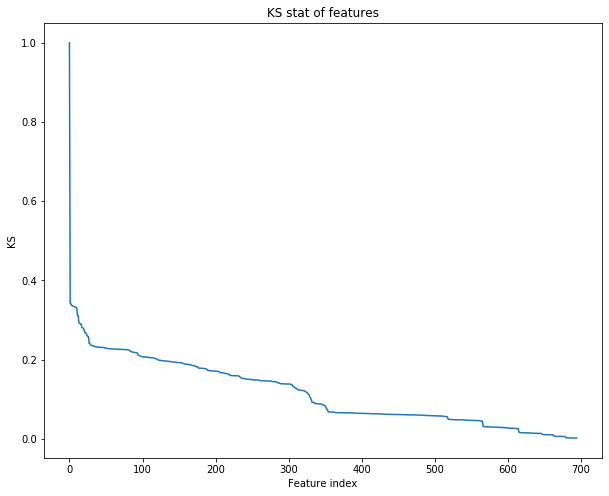

In [30]:
plt.figure(figsize=(10,8))
plt.plot(-np.sort(-KSFDR[0][:]))
plt.title("KS stat of features")
plt.ylabel('KS')
plt.xlabel('Feature index')
# plt.savefig("KS_HW5.png", dpi=200)
plt.show()

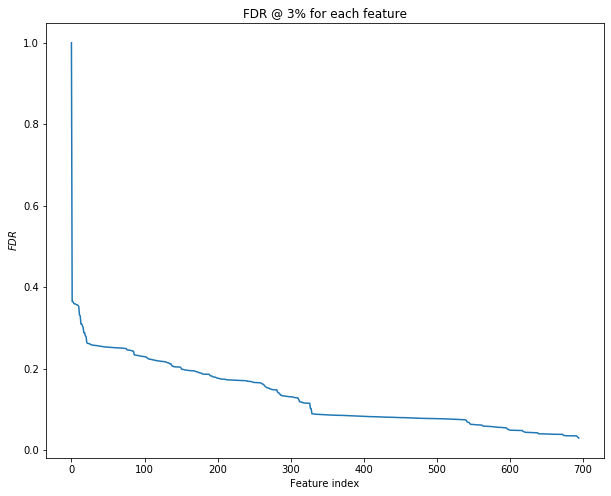

In [31]:
plt.figure(figsize=(10,8))
plt.plot(-np.sort(-KSFDR[1][:]))
plt.title("FDR @ 3% for each feature")
plt.ylabel('$FDR$')
plt.xlabel('Feature index')
plt.savefig("FDR_at_3.png", dpi=200)
plt.show()

In [32]:
columns_res = df_filter.columns
res_df_prof = pd.DataFrame.from_dict({'KS':KSFDR[0][:],'FDR':KSFDR[1][:]},orient='index',columns=columns_res)
res_df_prof = res_df_prof.transpose()
res_df_prof['Avg'] = res_df_prof.mean(axis = 1)
res_df_prof['KS Rank'] = res_df_prof['KS'].rank(ascending = False)
res_df_prof['FDR Rank'] = res_df_prof['FDR'].rank(ascending=False)
res_df_prof['Average Rank'] = res_df_prof[['KS Rank','FDR Rank']].mean(axis = 1)
res_df_prof_filter = res_df_prof.sort_values(by='Average Rank',ascending=True)
# res_df_filter = res_df_filter.drop(columns='rank_avg')
res_df_prof_filter

,KS,FDR,Avg,KS Rank,FDR Rank,Average Rank
fraud_label,1.000000,1.000000,1.000000,1.0,1.0,1.00
fullAddress_velocity30_date,0.340921,0.364875,0.352898,3.0,2.0,2.50
address_velocity30_date,0.341641,0.364439,0.353040,2.0,3.0,2.50
address_velocity90_date,0.336325,0.361031,0.348678,4.0,4.0,4.00
fullAddress_velocity90_date,0.335680,0.357973,0.346827,5.0,7.0,6.00
...,...,...,...,...,...,...
ssn_zip_velocity0_date,0.002045,0.034950,0.018497,686.0,691.0,688.50
dob_fullAddress_velocity0_date,0.001955,0.035125,0.018540,692.0,686.0,689.00
name_address_velocity0_date,0.001944,0.035125,0.018534,693.5,686.0,689.75
name_fullAddress_velocity0_date,0.001944,0.035125,0.018534,693.5,686.0,689.75


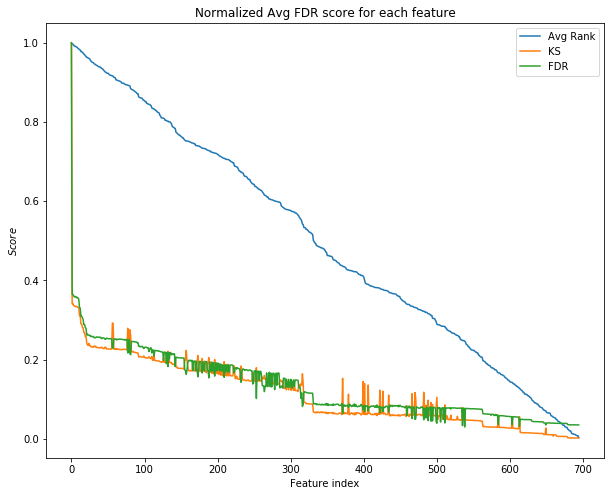

In [33]:
plt.figure(figsize=(10,8))
# plt.plot(KSFDR[1][:])
plt.plot(1-res_df_prof_filter['Average Rank'].values/res_df_prof_filter.shape[0],label = 'Avg Rank')
plt.plot(res_df_prof_filter['KS'].values,label = 'KS')
plt.plot(res_df_prof_filter['FDR'].values,label = 'FDR')
plt.title("Normalized Avg FDR score for each feature")
plt.ylabel('$Score$')
plt.xlabel('Feature index')
plt.legend()
# plt.savefig("Avg_Score.png", dpi=200)
plt.show()

In [34]:
Y_labels = df_filter['fraud_label']
features_chosen_filter = res_df_prof_filter.index.values[1:101] #1st column is the fraud label
features_chosen_filter

array(['fullAddress_velocity30_date', 'address_velocity30_date',
       'address_velocity90_date', 'fullAddress_velocity90_date',
       'address_velocity180_date', 'fullAddress_pastDays',
       'address_pastDays', 'fullAddress_velocity180_date',
       'address_velocity14_date', 'fullAddress_velocity14_date',
       'address_velocity7_date', 'fullAddress_velocity7_date',
       'address_velocity3_date', 'fullAddress_velocity3_date',
       'address_0_dayvel_div_14_dayvel_relvelocity',
       'fullAddress_0_dayvel_div_14_dayvel_relvelocity',
       'address_velocity1_date', 'fullAddress_velocity1_date',
       'address_0_dayvel_div_7_dayvel_relvelocity',
       'fullAddress_0_dayvel_div_7_dayvel_relvelocity',
       'address_velocity0_date', 'homephone_address_velocity30_date',
       'homephone_zip_velocity30_date', 'fullAddress_velocity0_date',
       'homephone_fullAddress_velocity30_date',
       'homephone_address_velocity90_date', 'ssn_dob_velocity30_date',
       'homephone_add

In [35]:
X_data = df_filter[features_chosen_filter]
print(X_data.shape)
X_data.head()

(792268, 100)


,fullAddress_velocity30_date,address_velocity30_date,address_velocity90_date,fullAddress_velocity90_date,address_velocity180_date,fullAddress_pastDays,address_pastDays,fullAddress_velocity180_date,address_velocity14_date,fullAddress_velocity14_date,address_velocity7_date,fullAddress_velocity7_date,address_velocity3_date,fullAddress_velocity3_date,address_0_dayvel_div_14_dayvel_relvelocity,fullAddress_0_dayvel_div_14_dayvel_relvelocity,address_velocity1_date,fullAddress_velocity1_date,address_0_dayvel_div_7_dayvel_relvelocity,fullAddress_0_dayvel_div_7_dayvel_relvelocity,address_velocity0_date,homephone_address_velocity30_date,homephone_zip_velocity30_date,fullAddress_velocity0_date,homephone_fullAddress_velocity30_date,homephone_address_velocity90_date,ssn_dob_velocity30_date,homephone_address_pastDays,dob_lastname_velocity30_date,name_dob_velocity30_date,homephone_zip_velocity90_date,homephone_address_velocity180_date,homephone_fullAddress_velocity90_date,dob_firstname_velocity30_date,ssn_velocity30_date,homephone_zip_pastDays,ssn_firstname_velocity30_date,name_dob_ssn_velocity30_date,homephone_fullAddress_pastDays,ssn_lastname_velocity30_date,homephone_fullAddress_velocity180_date,homephone_zip_velocity180_date,name_ssn_velocity30_date,dob_lastname_pastDays,ssn_dob_pastDays,fullAddress_0_dayvel_div_3_dayvel_relvelocity,address_0_dayvel_div_3_dayvel_relvelocity,ssn_dob_velocity180_date,dob_firstname_pastDays,name_dob_pastDays,ssn_velocity90_date,ssn_dob_velocity90_date,ssn_pastDays,dob_firstname_velocity90_date,name_dob_velocity180_date,address_0_dayvel_div_30_dayvel_relvelocity,fullAddress_0_dayvel_div_30_dayvel_relvelocity,ssn_velocity180_date,homephone_address_velocity14_date,dob_lastname_velocity90_date,ssn_firstname_pastDays,name_dob_velocity90_date,ssn_firstname_velocity90_date,name_dob_ssn_pastDays,dob_lastname_velocity180_date,ssn_lastname_pastDays,ssn_firstname_velocity180_date,name_dob_ssn_velocity180_date,name_ssn_velocity180_date,homephone_zip_velocity14_date,ssn_lastname_velocity90_date,name_dob_ssn_velocity90_date,ssn_lastname_velocity180_date,name_ssn_velocity90_date,dob_firstname_velocity180_date,name_ssn_pastDays,address_0_dayvel_div_90_dayvel_relvelocity,address_0_dayvel_div_180_dayvel_relvelocity,homephone_fullAddress_velocity14_date,fullAddress_0_dayvel_div_90_dayvel_relvelocity,fullAddress_0_dayvel_div_180_dayvel_relvelocity,dob_lastname_velocity14_date,dob_firstname_velocity14_date,name_velocity30_date,name_dob_velocity14_date,ssn_velocity14_date,ssn_dob_velocity14_date,ssn_firstname_velocity14_date,name_dob_ssn_velocity14_date,ssn_lastname_velocity14_date,name_ssn_velocity14_date,address_1_dayvel_div_14_dayvel_relvelocity,dob_lastname_0_dayvel_div_30_dayvel_relvelocity,homephone_address_velocity7_date,ssn_dob_0_dayvel_div_30_dayvel_relvelocity,homephone_zip_velocity7_date,name_dob_0_dayvel_div_30_dayvel_relvelocity,homephone_fullAddress_velocity7_date,homephone_velocity7_date,fullAddress_1_dayvel_div_14_dayvel_relvelocity
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
41240,-0.094400,-0.108163,-0.168630,-0.150229,-0.201823,0.402897,0.427984,-0.201107,-0.083728,-0.075811,-0.070745,-0.066136,-0.061218,-0.058728,0.148509,0.131911,-0.053663,-0.052302,0.114749,0.102256,-0.04995,-0.086778,-0.087551,-0.04897,-0.086645,-0.146869,-0.084168,0.376396,-0.088856,-0.084416,-0.148653,-0.198682,-0.146578,-0.096038,-0.089788,0.380249,-0.088363,-0.083932,0.375865,-0.088351,-0.198292,-0.201361,-0.088178,0.379323,0.366608,0.079363,0.087144,-0.193090,0.394092,0.367762,-0.145185,-0.142577,0.392159,-0.158700,-0.193057,0.200003,0.179956,-0.177214,-0.066358,-0.150855,0.389816,-0.142915,-0.152487,0.365750,-0.198867,0.389753,-0.207632,-0.192451,-0.207141,-0.066789,-0.152468,-0.142074,-0.207577,-0.152110,-0.195533,0.389111,0.308787,0.390597,-0.066297,0.286413,0.368278,-0.066881,-0.070984,-0.200123,-0.064444,-0.067669,-0.064294,-0.066457,-0.064184,-0.066426,-0.066354,0.14017,0.1

In [36]:
# Wrapper
from sklearn.metrics import make_scorer
def custom_FDR(y_true, y_scores):
    res_df = pd.DataFrame({'score':y_scores,'label': y_true}).sort_values(by='score',ascending=False)
    top3_res1 = res_df.head(round(y_true.shape[0]*0.03))
    return (top3_res1['label'].sum()/sum(y_true))

my_fdr_metric = make_scorer(custom_FDR, greater_is_better=True,needs_proba = True)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from warnings import filterwarnings # this is to ignore convergence warnings
filterwarnings('ignore')

log_reg = LogisticRegression()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv_logreg = RFECV(estimator=log_reg, step=1, cv=StratifiedKFold(2),min_features_to_select=30,
              scoring=my_fdr_metric,n_jobs=-1)

rfecv_logreg.fit(X_data, Y_labels)
print("Number of features chosen: %d" % rfecv_logreg.n_features_)

Number of features chosen: 77


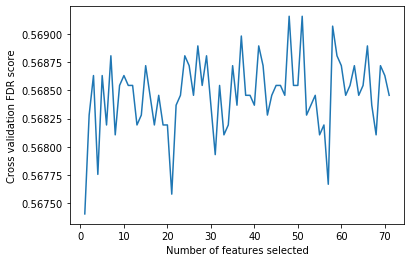

['fullAddress_velocity30_date' 'address_velocity30_date'
 'address_velocity90_date' 'fullAddress_velocity90_date'
 'address_velocity180_date' 'fullAddress_pastDays' 'address_pastDays'
 'fullAddress_velocity180_date' 'address_velocity14_date'
 'fullAddress_velocity14_date' 'address_velocity7_date'
 'address_0_dayvel_div_14_dayvel_relvelocity'
 'fullAddress_0_dayvel_div_14_dayvel_relvelocity' 'address_velocity1_date'
 'fullAddress_velocity1_date'
 'fullAddress_0_dayvel_div_7_dayvel_relvelocity'
 'homephone_address_velocity30_date' 'homephone_zip_velocity30_date'
 'fullAddress_velocity0_date' 'homephone_fullAddress_velocity30_date'
 'homephone_address_velocity90_date' 'ssn_dob_velocity30_date'
 'homephone_address_pastDays' 'dob_lastname_velocity30_date'
 'name_dob_velocity30_date' 'homephone_address_velocity180_date'
 'homephone_fullAddress_velocity90_date' 'ssn_firstname_velocity30_date'
 'name_dob_ssn_velocity30_date' 'homephone_fullAddress_pastDays'
 'ssn_lastname_velocity30_date' 'hom

In [38]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation FDR score")
plt.plot(range(1, len(rfecv_logreg.grid_scores_) + 1), rfecv_logreg.grid_scores_)
plt.show()

#---------------------save to dataframes -----------------------------
var_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv_logreg.ranking_), X_data)),
                            columns = ['ranking', 'variable'])
var_selected.to_csv('fs_logreg_ranks.csv')

scores_csv = pd.DataFrame(rfecv_logreg.grid_scores_,columns = ['Score'])
scores_csv.to_csv('fs_logreg_scores.csv')

features_chosen_wrapper = X_data.columns[rfecv_logreg.support_].values
print(features_chosen_wrapper)

In [43]:
# dataframe with RFECV ranking results
var_selected.tail(24)

,ranking,variable
76,1,ssn_pastDays
77,2,dob_firstname_pastDays
78,3,address_velocity0_date
79,4,ssn_dob_velocity14_date
80,5,fullAddress_1_dayvel_div_14_dayvel_relvelocity
81,6,ssn_velocity14_date
82,7,fullAddress_velocity3_date
83,8,name_dob_ssn_velocity14_date
84,9,name_ssn_velocity180_date
85,10,dob_firstname_velocity30_date


final_wrapper_columns = var_selected_rfe.variable.values[:30]

In [44]:
from sklearn.feature_selection import RFE


log_reg = LogisticRegression()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfe_logreg = RFE(estimator=log_reg, step=1, n_features_to_select=1)
rfe_logreg.fit(X_data[features_chosen_wrapper], Y_labels)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [45]:
var_selected_rfe = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfe_logreg.ranking_), X_data[features_chosen_wrapper])),
                            columns = ['ranking', 'variable'])
var_selected_rfe.to_csv('fs_logreg_ranks91.csv')

In [46]:
selected_columns_rfe = X_data[features_chosen_wrapper].columns[rfe_logreg.support_].values
print(selected_columns_rfe)

['homephone_address_pastDays']


In [47]:
var_selected_rfe

,ranking,variable
0,1,homephone_address_pastDays
1,2,homephone_fullAddress_pastDays
2,3,name_dob_velocity30_date
3,4,homephone_fullAddress_velocity30_date
4,5,homephone_address_velocity30_date
5,6,fullAddress_velocity30_date
6,7,homephone_fullAddress_velocity14_date
7,8,fullAddress_velocity14_date
8,9,fullAddress_0_dayvel_div_30_dayvel_relvelocity
9,10,fullAddress_0_dayvel_div_14_dayvel_relvelocity


In [48]:
final_wrapper_columns = var_selected_rfe.variable.values[:30]
final_wrapper_columns

array(['homephone_address_pastDays', 'homephone_fullAddress_pastDays',
       'name_dob_velocity30_date',
       'homephone_fullAddress_velocity30_date',
       'homephone_address_velocity30_date', 'fullAddress_velocity30_date',
       'homephone_fullAddress_velocity14_date',
       'fullAddress_velocity14_date',
       'fullAddress_0_dayvel_div_30_dayvel_relvelocity',
       'fullAddress_0_dayvel_div_14_dayvel_relvelocity',
       'ssn_lastname_velocity14_date', 'fullAddress_pastDays',
       'homephone_zip_velocity30_date', 'name_dob_pastDays',
       'ssn_dob_pastDays', 'homephone_address_velocity180_date',
       'homephone_fullAddress_velocity180_date',
       'homephone_velocity7_date', 'name_ssn_velocity14_date',
       'name_ssn_velocity30_date',
       'fullAddress_0_dayvel_div_180_dayvel_relvelocity',
       'name_dob_ssn_velocity30_date',
       'ssn_dob_0_dayvel_div_30_dayvel_relvelocity',
       'name_dob_0_dayvel_div_30_dayvel_relvelocity',
       'address_velocity14_date